In [1]:
import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return
    


In [22]:
import requests
from PIL import Image

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
image



#image = Image.open("images.jpeg")
#image

#image = Image.open("frame_0106.jpg")
#image

#image = Image.open("dino_v2.jpeg")
#image

from transformers import ViTFeatureExtractor

#feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/dino-vits8", size=480)

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/dinov2-giant", size=480)


pixel_values = feature_extractor(images=image, return_tensors="pt").pixel_values 
print(pixel_values.shape)

from transformers import ViTModel

#model = ViTModel.from_pretrained("facebook/dino-vits8", add_pooling_layer=False)

model = ViTModel.from_pretrained("facebook/dinov2-giant", add_pooling_layer=False)

# forward pass
outputs = model(pixel_values, output_attentions=True, interpolate_pos_encoding=True)

attentions = outputs.attentions[-1] # we are only interested in the attention maps of the last layer
nh = attentions.shape[1] # number of head

print("# number of head")
print(nh)

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
# attentions[0, :, 0, 1:]: Slices the attentions tensor to extract specific parts:
# 0: The first index corresponds to the batch dimension. Assuming a batch size of 1, this selects the first (and only) item in the batch.
# :: The colon in the second position means all attention heads are selected.
# 0: The third index selects the query position. In Vision Transformers, the first token (0) is typically the classification token (CLS token), which aggregates information from the entire image.
# 1:: The fourth index slices the key positions, starting from index 1 to exclude the CLS token itself. This means we're interested in how the CLS token attends to all other patches in the image.

print(attentions.shape)




torch.Size([1, 3, 480, 480])


You are using a model of type dinov2 to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dinov2-giant and are newly initialized: ['encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.layernorm_after.bias', 'encoder.layer.0.layernorm_after.weight', 'encoder.layer.0.layernorm_before.bias', 'encoder.layer.0.layernorm_before.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.layernorm_after.bias', 'encoder.layer.1.layernorm_after.weight', 'encoder.layer.1.layernorm_before.bias', 'encoder.layer.1.layernorm_before.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.int

# number of head
24
torch.Size([24, 1156])


/tmp/ipykernel_14254/268936690.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


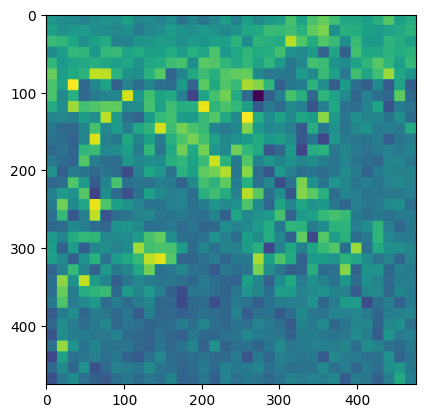

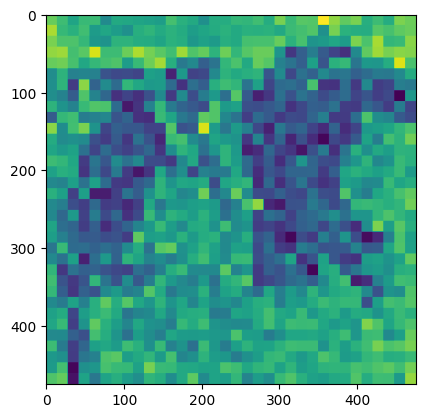

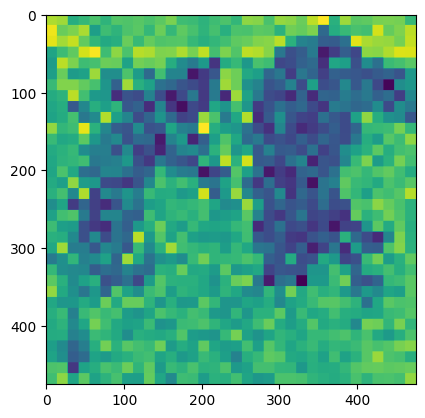

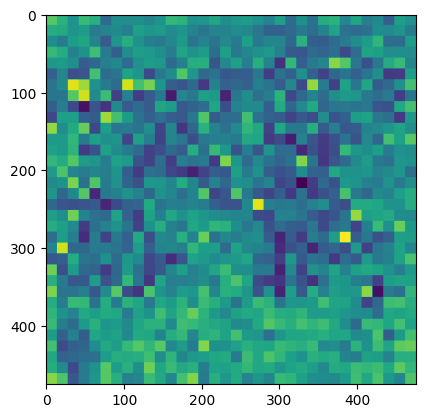

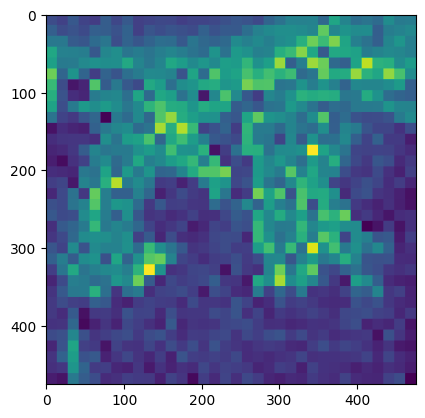

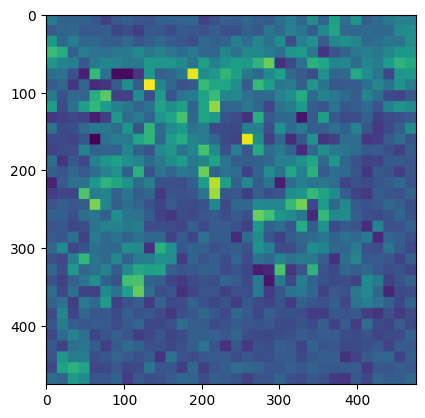

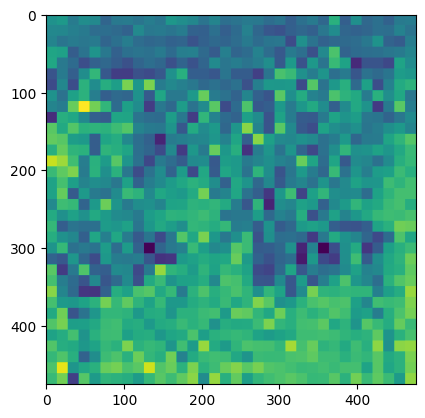

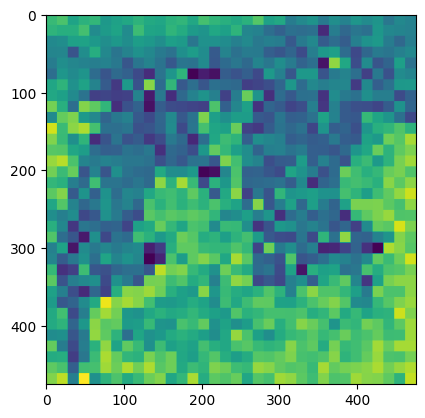

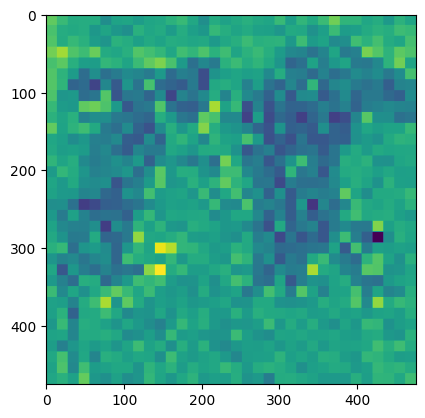

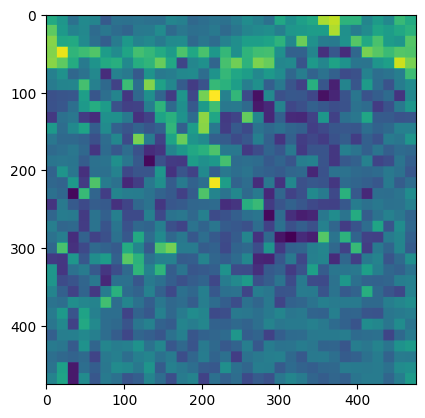

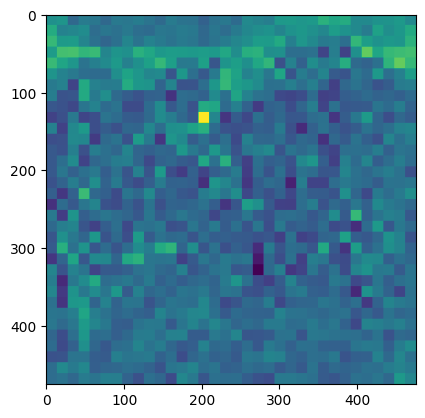

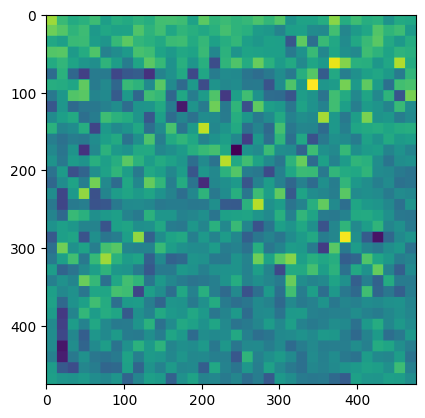

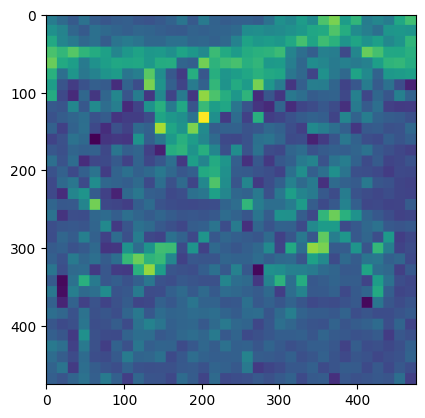

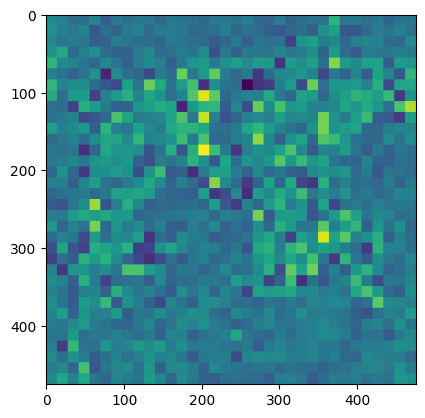

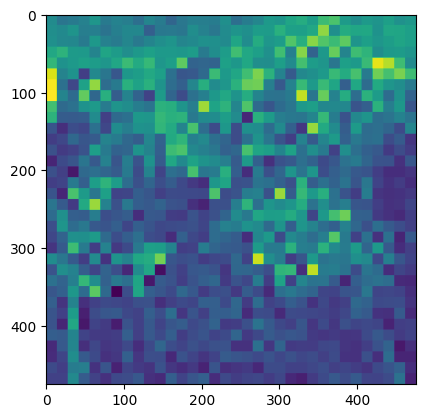

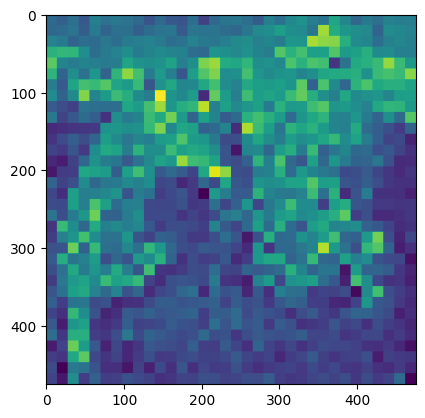

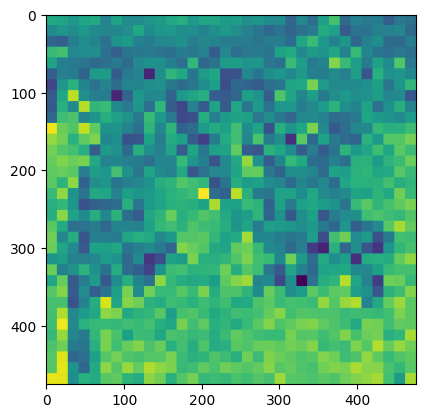

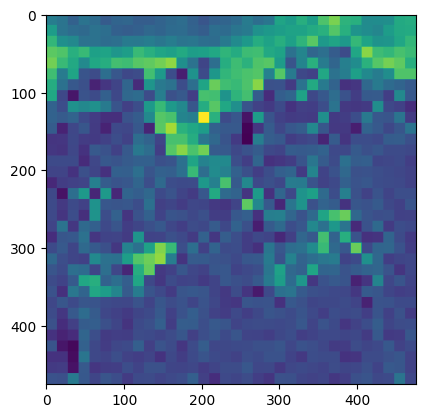

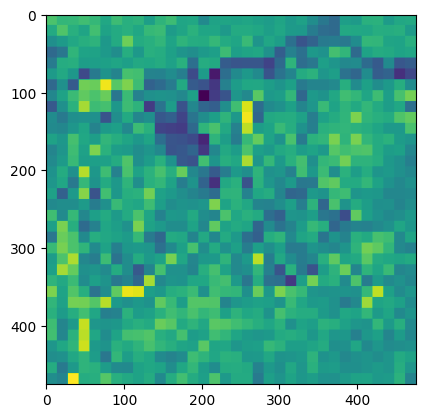

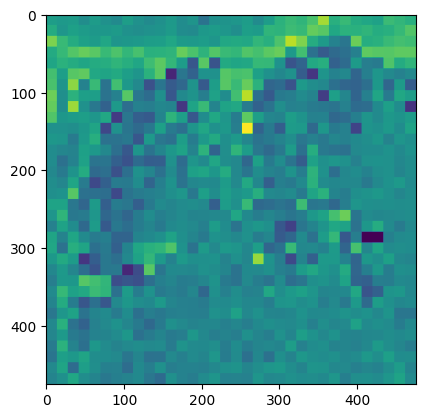

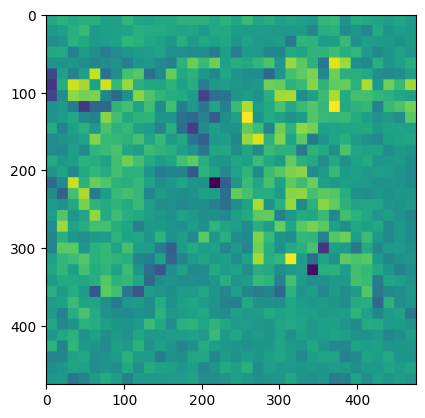

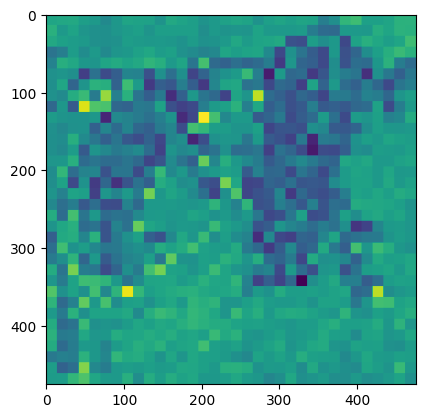

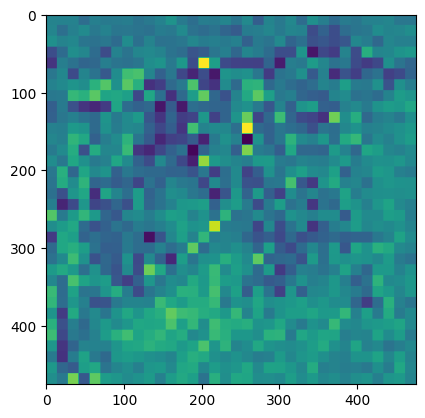

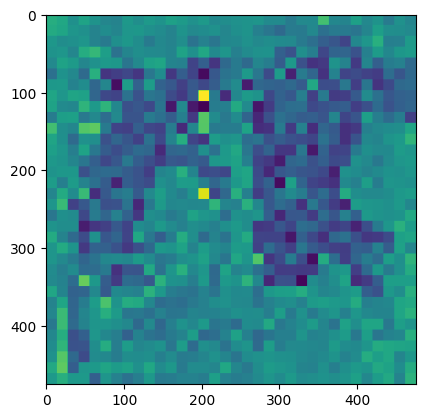

In [23]:
import os
import torch
import torch.nn as nn
import torchvision

# Purpose: Defines a threshold value (threshold) set to 0.6. This value will later be used to retain only the top 60% of attention weights, effectively filtering out less significant attention values.
threshold = 0.8

# model.config.patch_size: Accesses the patch_size attribute from the model's configuration. Vision Transformers divide images into patches of size patch_size x patch_size.
w_featmap = pixel_values.shape[-2] // model.config.patch_size
h_featmap = pixel_values.shape[-1] // model.config.patch_size



# we keep only a certain percentage of the mass
# Purpose: Sorts the attention weights in ascending order for each attention head.
# Context: Sorting is essential for identifying and retaining the most significant attention weights based on the defined threshold.
val, idx = torch.sort(attentions)

# Purpose: Normalizes the sorted attention values so that they sum to 1 for each attention head.
# torch.sum(val, dim=1, keepdim=True): Calculates the sum of the sorted attention values along dimension 1 (assuming dimension 0 is the batch and dimension 1 is the attention head). keepdim=True retains the dimension after the sum, resulting in a tensor that can be broadcasted during division.4
# Result: Each row in val now represents a normalized distribution of attention weights for an attention head.
val /= torch.sum(val, dim=1, keepdim=True)

# Purpose: Computes the cumulative sum of the normalized attention values for each attention head.
# If val for a head is [0.1, 0.2, 0.3, 0.4], then cumval becomes [0.1, 0.3, 0.6, 1.0].
cumval = torch.cumsum(val, dim=1)

# Purpose: Creates a boolean mask (th_attn) that identifies which attention values to retain based on the defined threshold.
# Example:

# Using the earlier example, cumval = [0.1, 0.3, 0.6, 1.0].

# cumval > 0.4 results in [False, False, True, True].


th_attn = cumval > (1 - threshold)


# Purpose: Computes the inverse of the sorting indices to reorder the mask (th_attn) back to the original attention order.
# Context: Since th_attn was applied to the sorted attention values, reordering it with idx2 aligns the mask back to the original unsorted attention weights.
idx2 = torch.argsort(idx)

# Purpose: Reorders the boolean mask th_attn for each attention head to match the original attention weight ordering.
# Context: After sorting and applying the threshold, this step ensures that the mask correctly corresponds to the original attention weight positions, not the sorted ones.


for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
    
# If nh = 12, w_featmap = 60, and h_featmap = 60, then th_attn becomes a tensor of shape [12, 60, 60].
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()


# interpolate
# Purpose: Enlarges the attention mask (th_attn) to match the original image dimensions by scaling it up using nearest-neighbor interpolation.
# Result: th_attn is now a NumPy array of shape [nh, original_width, original_height], with attention masks scaled to the original image size.
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=model.config.patch_size, mode="nearest")[0].cpu()
attentions = attentions.detach().numpy()

# show and save attentions heatmaps
output_dir = '.'
os.makedirs(output_dir, exist_ok=True)
torchvision.utils.save_image(torchvision.utils.make_grid(pixel_values, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
for j in range(nh):
    fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
    plt.figure()
    plt.imshow(attentions[j])
    plt.imsave(fname=fname, arr=attentions[j], format='png')
    #print(f"{fname} saved.")
    
    

